<div style="float: right">
    **Школа Анализа Данных** — https://yandexdataschool.ru

    <div style="margin-top: 20px">
        <img src="https://yastatic.net/yandex-shad2-www/_/PrcFTNsjcxFOmIVCu7Vzrm4sZFM.svg" width="300px">
    </div>
</div>

# Лабораторная работа 1

Не забываем загрузить библиотеки:

In [1]:
# Библиотека для работы с матрицами
import numpy as np 

# Алгоритмы линейной алгебры
import scipy.linalg as sla

# Библиотека для работы с разреженными матрицами
import scipy.sparse as sps

# Алгоритмы линейной алгебры для разреженных матриц
import scipy.sparse.linalg as spla

# Графическая библиотека
import matplotlib.pyplot as plt

# Библиотека для измерения времени
import timeit

# Позволяет отрисовывать графики и изображения прямо в ноутбуке, а не в отдельном окне. Жизненно важная вещь!
%matplotlib inline

## Часть 1. Особенности LU-разложения

С точки зрения математики матричные разложения являются точными: произведение сомножителей всегда равняется исходной матрицы $A$. К сожалению, на практике этом часто мешает вычислительная погрешность. 

Для $LU$ разложения l2-норма ошибки ошибки $||\delta A|| = ||A - LU||$ удовлетворяет следующей оценке:

$$||\delta A|| \leqslant ||L|| \cdot ||U|| \cdot O(\varepsilon_{machine})$$

А нормы $L$ и $U$ могут быть совсем нехорошими.

**Задание 1.1 (1 балл)** Рассмотрим следующее LU-разложение:

$$\begin{pmatrix}
10^{-20} & 1\\
1 & 1
\end{pmatrix} = \begin{pmatrix}
1 & 0\\
10^{20} & 1
\end{pmatrix}\cdot\begin{pmatrix}
10^{-20} & 1\\
0 & 1 - 10^{20}
\end{pmatrix}$$

Перемножьте полученные матрицы $L$ и $U$. А теперь перемножьте такие же матрицы, только после всех единиц поставьте десятичные точки. Изменился ли ответ? Как вам кажется, почему?

In [2]:
# YOUR CODE HERE
L_int = np.array([[1, 0],
             [int(1e20), 1]])
U_int = np.array([[1e-20, 1],
             [0, 1 - int(1e20)]])

L_float = np.array(L_int, dtype = float)
U_float = np.array(U_int, dtype = float)

print('Произведение целочисленных матриц:')
print(L_int.dot(U_int), end='\n\n')
print('Произведение матриц с дробным типом:')
print(L_float.dot(U_float), end='\n\n')

Произведение целочисленных матриц:
[[1e-20 1]
 [1.0 1]]

Произведение матриц с дробным типом:
[[  1.00000000e-20   1.00000000e+00]
 [  1.00000000e+00   0.00000000e+00]]



Результат произведения целочисленных матриц:
$$\begin{pmatrix}
10^{-20} & 1\\
1 & 1
\end{pmatrix} $$
Результат произведения дробных матриц:
$$\begin{pmatrix}
10^{-20} & 1\\
1 & 0
\end{pmatrix}$$
Как видно, результат произведение целочисленных матриц совпадает с математическими расчётами, 
      в то время как результат произведения дробных матриц отличается от ожидания. Это связано с тем, 
      что целые числа хранятся точно, а числа с плавающей точкой нет: $1 - 10^{20}$ и $-10^{20}$, хранимые как float - одно и тоже для компьютера.

**Выход: LU-разложение с выбором главного элемента (по столбцу)**

Каждый раз ищем максимум в столбце и переставляем соответствующую строку наверх.

$$\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow
\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow$$
$$\longrightarrow\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & 0 & b'_{i+1,i+1} & \dots & b'_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & 0 & b'_{i,i+1} & \dots & b'_{in} \\
 & & \vdots & \vdots & & \vdots
\end{pmatrix}$$

Надо сказать, что примерно так вы все и решали системы на первом курсе университета! Именно наибольший, а не первый ненулевой элемент столбца берётся потому, что чем больше число - тем меньшие погрешности потенциально вносит деление на него.

Что при этом происходит? Перестановка строк матрицы равносильна умножению её слева на матрицу соответствующей перестановки. Таким образом, мы получаем равенство

$$L_nP_nL_{n-1}P_{n-1}\ldots L_2P_2L_1P_1 A = U\qquad\qquad(1)$$

где $L_1,\ldots,L_n$ - некоторые нижнетреугольные матрицы.

**Вопрос:** Ну, и где здесь матрица $L$?!

**Ответ:** Введём новые матрицы

\begin{align*}
L'_n &= L_n\\
L'_{n-1} &= P_nL_nP_{n-1}\\
L'_{n-2} &= P_nP_{n-1}L_{n-1}P_n^{-1}P_{n-1}^{-1}\\
&\ldots\\
L'_1 &= P_nP_{n-1}\ldots P_2L_1P_2^{-1}\ldots P_{n-1}^{-1}P_n^{-1}
\end{align*}

**Упражнение.** Матрицы $L'_i$ тоже нижнетреугольные!

Тогда левая часть (1) перепишется в виде

$$\underbrace{L'_nL'_{n-1}\ldots L'_1}_{:=L^{-1}}\underbrace{P_nP_{n-1}\ldots P_1}_{:=P^{-1}}\cdot A$$

**Итог:** разложение вида
$$A = PLU$$
где $P$ - матрица перестановки.

Функция `scipy.linalg.lu` в Питоне находит именно такое разложение!

Все элементы $L$ не превосходят $1$, так что $||L||]\leqslant 1$. При этом
$$||\Delta A|| \leqslant ||A||\cdot O(\rho \varepsilon_{machine}),$$
где
$$\rho = \frac{\max_{i,j}|u_{ij}|}{\max_{i,j}|a_{ij}|}$$
Это число называется *фактором роста матрицы*.

Но что, если это отношение велико?

**Задание 1.2 (1 балл)** Сгенерируйте матрицу $500\times500$, имеющую вид

$$\begin{pmatrix}
1 & 0 & 0 & \cdots & 0 & 0 & 1\\
-1 & 1 & 0 &  &  & 0 & 1\\
-1 & -1 & 1 & 0  &  & 0 & 1\\
\vdots & & \ddots & \ddots  & \ddots & \vdots & \vdots \\
-1 & -1 & -1 & \ddots & 1 & 0 & 1\\
-1 & -1 & -1 &  & -1 & 1 & 1\\
-1 & -1 & -1 & \cdots & -1 & -1 & 1
\end{pmatrix}$$

Например, вы можете сгенерировать сначала нулевую матрицу нужного размера, а потом заполнить её клетки правильными числами.

Найдите её PLU-разложение и QR-разложение. Убедитесь, что $P = E$. Вычислите $||A - LU||_2$ и $||A - QR||_2$. Чему равен фактор роста матрицы $A$?

In [3]:
# YOUR CODE HERE
A = np.zeros((500, 500))
for i in range(A.shape[0]):
    A[i, i] = 1
    A[i, -1] = 1
    for j in range(i):
        A[i, j] = -1

P, L, U = sla.lu(A)
Q, R = sla.qr(A)

def norm2(matrix):
    return sla.norm(matrix, axis=0).max()

print("P == E : {}".format((P == np.identity(500)).all()))
print("A - LU norm : {}".format(norm2(A - L @ U)))
print("A - QR norm : {}".format(norm2(A - Q @ R)))
print("A growth factor : {}".format(np.absolute(U).max()/np.absolute(A).max()))

P == E : True
A - LU norm : 3.102517070422723e+116
A - QR norm : 1.173142952228984e-13
A growth factor : 1.636695303948071e+150


К счастью, на практике так редко очень бывает (чёрт его знает почему). Тем не менее, QR-разложение всё-таки лучше. Теоретическая оценка для ошибки QR-разложения имеет вид

$$||A - QR||_2 \leqslant ||A||_2\cdot O(\varepsilon_{machine})$$

**Задание 1.3 (1 балл)** Рассмотрим *матрицу Паскаля* $S_n = \left(C_{i + j}^i\right)$ ($i,j = 0,\ldots,n-1$).

Каково её LU-разложение? Выведите формулы для матриц L и U и приведите краткое обоснование прямо в ноутбуке. Не пользуйтесь функцией `scipy.linalg.lu`, чтобы его "угадать": матрица P будет отлична от единичной, и вы получите не то, что хотели.

Каков её определитель?


$$S = LU$$
$$L_{ij} = C_{i}^{j}$$
$$ U = L^T$$
Тогда $S_{ij} = \sum\limits_{k=0}^{n-1} C_i^k C_j^k = \sum\limits_{k=0}^{min(i, j)} C_i^{i - k} C_j^k$
Последняя формула имеет следующий комбинаторный смысл: множство из $i+j$ элементов мы разбиваем на два множества из $i$ и $j$ элементов. Затем для всех $k$ выбираем $i-k$ элементное подмножество первого множества и для каждого выбранного подмножества выбираем k элементное подмножество второго множества. Но таким образом мы перебрали в точности все $i$ элементные подмножества исходного множества. То есть
$S_{ij} = C_{i+j}^i$
$$ det(S) = 1$$

Напишите функцию `my_pascal(n)`, генерирующую матрицу Паскаля размера $n\times n$.

In [4]:
def my_pascal(n):
    '''
    Ввод
    -----
    n - размерность матрицы
    
    Вывод
    ------
    Матрица Паская nxn
    '''
    # YOUR CODE HERE
    pascal = np.ones((n, n))
    for i in range(1, n):
        for j in range(1, n):
            pascal[i, j] = pascal[i - 1, j] + pascal[i, j - 1]
    return pascal

In [5]:
import numpy as np
my_rows = [1,2,3,5]
my_columns = [7, 4, 5, 1]
X = np.arange(100).reshape(10, 10)
X[my_rows,my_columns]

array([17, 24, 35, 51])

In [6]:
X[np.ix_(my_rows,my_columns)]

array([[17, 14, 15, 11],
       [27, 24, 25, 21],
       [37, 34, 35, 31],
       [57, 54, 55, 51]])

In [7]:
# Run this!

A_test = my_pascal(5)
assert A_test.shape == (5, 5)


Найдите норму разности $||A - PLU||_2$. Не такая уж и большая, правда?

In [8]:
P, L, U = sla.lu(A_test)
norm2(A_test - P @ L @ U)

0.0

Теперь попросим компьютер вычислить определитель матрицы Паскаля $30\times30$ и решить простенькую систему уравнений:

In [9]:
A = my_pascal(30)
print('determinant: ', sla.det(A))

# Try to solve a linear system
x = np.ones(30)
b = A.dot(x).reshape(30, 1) # для linalg.solve из scipy
x1 = sla.solve(A, b)
print('residual: ', sla.norm(x1 - x))

determinant:  1.0299188904699096e+48
residual:  1298100.28437


/opt/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.158005706474147e-23
  ' condition number: {}'.format(rcond), RuntimeWarning)


Так себе ошибка. Теперь попробуем сделать это с помощью QR-разложения. Станет ли лучше?

In [10]:
Q, R = sla.qr(A)
x2 = sla.solve_triangular(R, Q.T.dot(b))
print('residual: ', sla.norm(x2 - x))

residual:  1752649573.74


Объясните полученные неприятные результаты.

Из-за большой значений в правом нижнем углу и относительно маленьких в левом верхнем точности float не хватает для вычисления разлодения

## Часть 2. Решение СЛАУ с положительно определённой матрицей

**Задание 2.1. Какие же методы использовать? (3 балла)**

Реализуйте несколько алгоритмов решения СЛАУ $Ax = b$, где $A = A^T$, $A \geqslant 0$ с матричной правой частью $b$.

1. **Наивный способ**: $x = A^{-1}b$;

2. **Стандартный способ**: с помощью процедуры `solve` модуля `scipy.linalg`;

3. **Разложение Холецкого**: с помощью разложения Холецкого для матрицы $A$ и последующего решения двух СЛАУ с треугольными матрицами;

4. **Разложение Холецкого с процедурами scipy**: с помощью разложения Холецкого для матрицы $A$ и специальных процедур из пакета `scipy.linalg` (`cho_factor`, `cho_solve`).

Для решения СЛАУ с треугольной матрицей можно воспользоваться функцией `solve_triangular` из пакета `scipy.linalg`.

In [11]:
def naive_solve(A, b):
    return sla.inv(A).dot(b)

def standard_solve(A, b):
    return sla.solve(A, b)

def cholesky_solve(A, b):
    A_cho = sla.cholesky(A)
    return sla.solve_triangular(A_cho, sla.solve_triangular(A_cho.T, b, lower=True))

def cho_scipy_solve(A, b):
    return sla.cho_solve(sla.cho_factor(A), b)

Проведите тестирование реализованных алгоритмов на небольшой СЛАУ на предмет совпадения ответов

In [12]:
# Your test go here

def gen_A(size):
    X = np.random.randn(size, size)
    return X.dot(X.T)

def gen_b(*size):
    return np.random.randn(*size)

def test(A, b):
    eps = 1e-5
    answers = (naive_solve(A, b), standard_solve(A, b), cholesky_solve(A, b), cho_scipy_solve(A, b))
    for answer in answers:
        if np.max(A @ answer - b) > eps:
            return False
    return True

test(gen_A(1000), gen_b(1000))

True

In [13]:
# And can you beat our tests?


Проведите эксперименты и выясните, как меняется время работы этих методов

- с ростом размера матрицы $A$ при фиксированном числе правых частей. Рассмотрите системы с 10, 100, 1000 правых частей;

- с ростом числа правых частей при фиксированном размере матрицы $A$ (например, $100\times100$).

Обязательно нарисуйте графики (время работы от размера). Какой метод оказывается более быстрым?

Для тестирования вам пригодятся случайные матрицы, сгенерированные, например, с помощью функции `numpy.random.randn`. Но не забудьте, что в задаче речь идёт о *симметрических положительно определённых матрицах*. Так что подумайте, как из случайных матриц сделать симметрические положительно определённые.

Матрицы левых частей должны быть не менее $100\times100$: при меньших размерностях заметную роль могут играть факторы, не имеющие отношения к алгебре. Мы рекомендуем рассматривать системы с матрицами размера от 100 до 1000 и с числом правых частей от 10 до 10000. Приготовьтесь к тому, что эксперименты могут занять какое-то время.

In [14]:
times = {}
solvers = (naive_solve, standard_solve, cholesky_solve, cho_scipy_solve)
for b_size in (10, 100, 1000):
    print('Time for b size = {}'.format(b_size))
    times[b_size] = {}
    for solver in solvers:
        print(solver.__name__.ljust(15), end = ' ')
        times[b_size][solver] = []
        for A_size in range(100, 1000, 10):
            if not A_size%20:
                print('#', end = '')
            A = gen_A(A_size)
            b = gen_b(A_size, b_size)
            time = timeit.timeit(lambda : solver(A, b), number=1)
            times[b_size][solver].append(time)
        print()
print('Done!')

Time for b size = 10
naive_solve     #############################################
standard_solve  #############################################
cholesky_solve  #############################################
cho_scipy_solve #############################################
Time for b size = 100
naive_solve     #############################################
standard_solve  #############################################
cholesky_solve  #############################################
cho_scipy_solve #############################################
Time for b size = 1000
naive_solve     #############################################
standard_solve  #############################################
cholesky_solve  #############################################
cho_scipy_solve #############################################
Done!


Зависимость времени исполнения, от размера матрицы A в логарифмической шкале


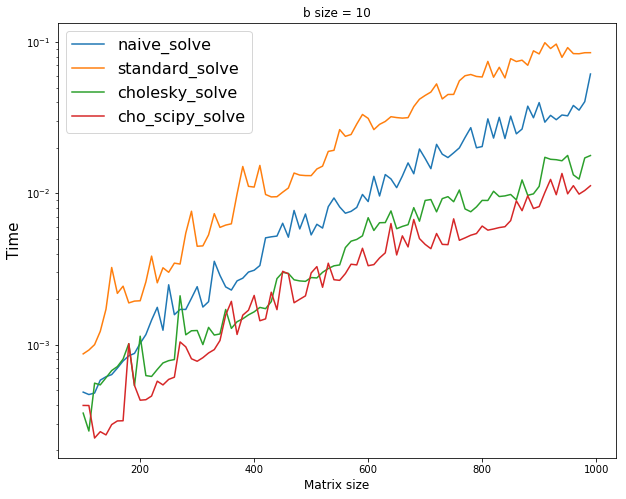

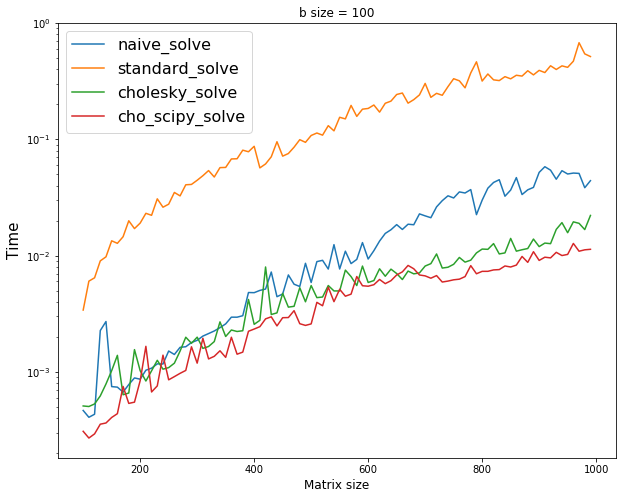

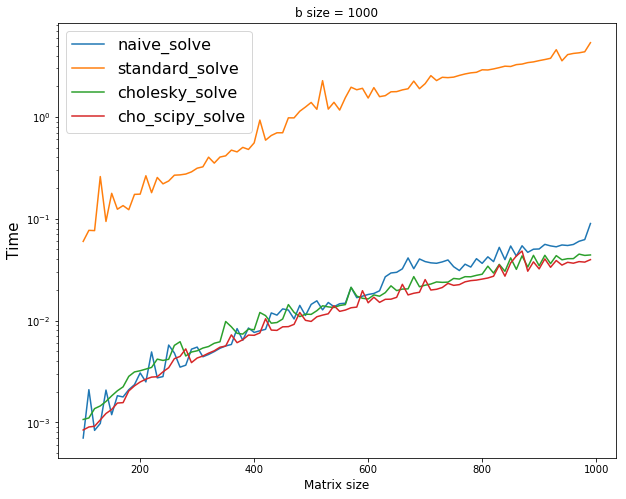

In [15]:
X = np.arange(100, 1000, 10)
print('Зависимость времени исполнения, от размера матрицы A в логарифмической шкале')
for b_size in (10, 100, 1000):
    plt.figure(figsize=(10, 8))
    for solver in solvers:
        plt.plot(X, times[b_size][solver], label=solver.__name__)
        plt.title('b size = {}'.format(b_size))
        plt.yscale('log')
        plt.xlabel('Matrix size', fontsize=12)
        plt.ylabel('Time', fontsize=15)
        plt.legend(prop={'size': 16})
    plt.show()

In [16]:
A_size = 100
for solver in solvers:
    print(solver.__name__.ljust(15), end = ' ')
    times[solver] = []
    for b_size in range(100, 10001, 100):
        if not b_size%200:
                print('#', end = '')
        A = gen_A(A_size)
        b = gen_b(A_size, b_size)
        time = timeit.timeit(lambda : solver(A, b), number=1)
        times[solver].append(time)
    print()
print('Done!')

naive_solve     ##################################################
standard_solve  ##################################################
cholesky_solve  ##################################################
cho_scipy_solve ##################################################
Done!


Зависимость времени исполнения, от размера правой части b в логарифмической шкале


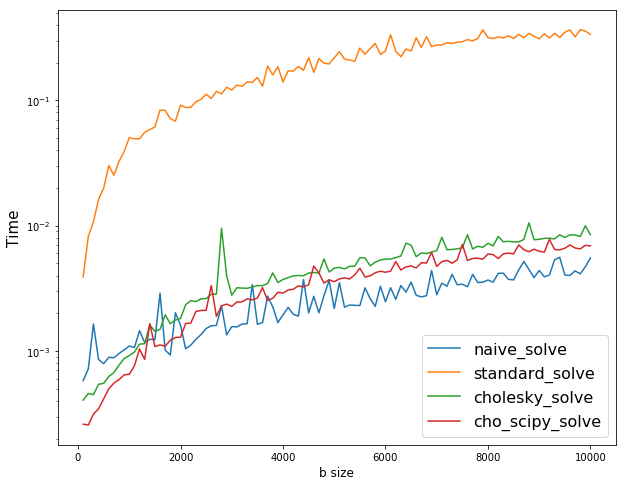

In [17]:
X = np.arange(100, 10001, 100)
print('Зависимость времени исполнения, от размера правой части b в логарифмической шкале')
plt.figure(figsize=(10, 8))
for solver in solvers:
    plt.plot(X, times[solver], label=solver.__name__)
    plt.yscale('log')
    plt.xlabel('b size', fontsize=12)
    plt.ylabel('Time', fontsize=15)
    plt.legend(prop={'size': 16})

Как видно метод использующий реализацию разложения Холецкого из scipy работает быстрее всего, хотя не сильно выигрывает у наивной реализации и solve_triangular. А вот стандартная реализация очень сильно проигрывает, причём тем больше, чем больше размер матрицы.

**Задание 2.2. Пример: вычисление логарифма плотности многомерного нормального распределения (3 балла)**

Случайная величина $\vec{x}\in\mathbb{R}^D$ имеет многомерное нормальное распределение, если её плотность может быть представлена как
$$
p(\vec{x}) = \mathcal{N}(\vec{x}|\vec{\mu},\Sigma) = \frac{1}{\sqrt{2\pi}^D\sqrt{\det\Sigma}}\exp\left(-\frac{1}{2}(\vec{x}-\vec{\mu})^T\Sigma^{-1}(\vec{x}-\vec{\mu})\right)
$$
Здесь $\vec{\mu}\in\mathbb{R}^D -$ вектор мат. ожидания $\vec{x}$, а $\Sigma\in\mathbb{R}^{D{\times}D} -$ матрица ковариации.

С помощью матричных разложений реализуйте алгоритм вычисления логарифма нормальной плотности для набора векторов $X = \{\vec{x}_1,\dots,\vec{x}_N\}$ для заданных $\vec{\mu}$ и $\Sigma$.

In [120]:
from scipy.stats import multivariate_normal

#Заготовка:
def my_multivariate_normal_logpdf(X, m, S):
    '''
    Ввод
    -----
    X: набор точек, numpy array размера N x D;
    m: вектор средних значений, numpy array длины D;
    S: ковариационная матрицы, numpy array размера D x D.
    
    Вывод
    ------
    res: результат вычислений, numpy array длины N.
    '''
    U = sla.cho_factor(S)
    det_sqr = np.diagonal(U[0]).prod()
    X0 = X - m[None, :]
    Y = sla.cho_solve(U, X0.T)
    # Здесь логарифм произведения превращён в сумму логарифмов, потому что иначе при больших размерностях 
    # не хватает точности логарифм становится равен inf
    return - len(m) / 2 * np.log(2*np.pi) - np.log(U[0].diagonal()).sum() - (X0.T * Y).sum(axis=0) / 2

In [86]:
# Run this!

X_testing = np.random.multivariate_normal(np.zeros(6), np.eye(6), 5)
assert my_multivariate_normal_logpdf(X_testing, np.zeros(6), np.eye(6)).shape == (5,)


Замерьте время работы вашего алгоритма и функции `scipy.stats.multivariate_normal.logpdf` для различных значений $D$. Постарайтесь добиться, чтобы ваш алгоритм выигрывал по скорости у стандартной функции.

In [122]:
# Here lie the time tests!


In [123]:
# Your experiments go here

X_sizes = (10, 50, 100, 500)
D_sizes = range(5, 500, 50)
my_times = {}
st_times = {}
for X_size in X_sizes:
    my_times[X_size] = []
    st_times[X_size] = []
    for D in D_sizes:
        while True:
            try:
                A = gen_A(D)
                m = np.random.randn(D)
                X = gen_b(X_size, D)
                my_time = timeit.timeit(lambda : my_multivariate_normal_logpdf(X, m, A), number=1)
                st_time = timeit.timeit(lambda : multivariate_normal.logpdf(X, m, A), number=1)
                break
            except sla.LinAlgError: #  For cathcing singular matrix, that rarely appear
                pass
        my_times[X_size].append(my_time)
        st_times[X_size].append(st_time)

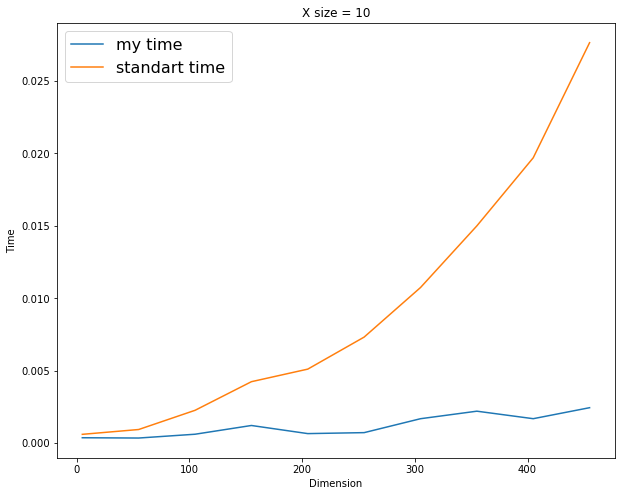

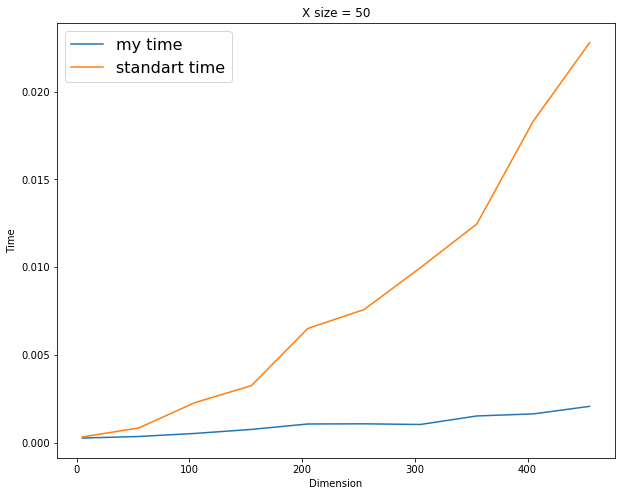

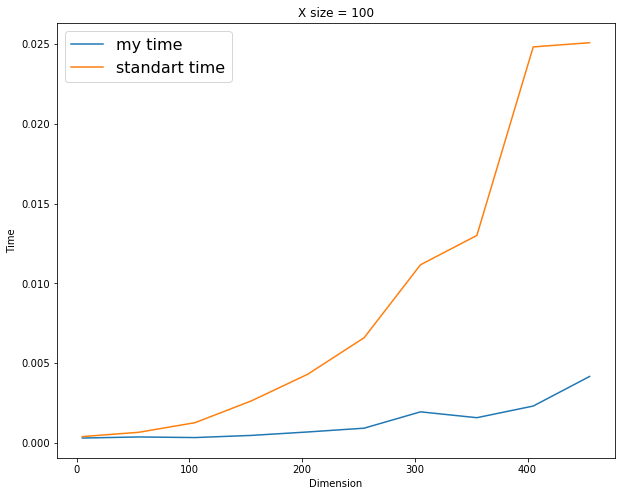

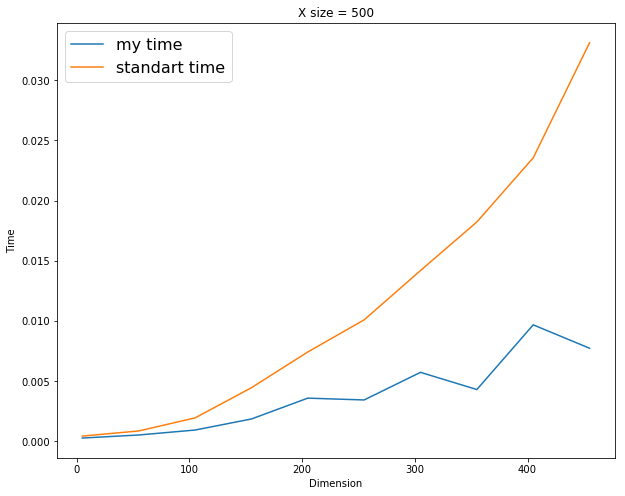

In [124]:
for X_size in X_sizes:
    plt.figure(figsize=(10, 8))
    plt.plot(D_sizes, my_times[X_size], label = 'my time')
    plt.plot(D_sizes, st_times[X_size], label = 'standart time')
    plt.legend(prop={'size': 16})
    plt.title('X size = {}'.format(X_size))
    plt.xlabel('Dimension')
    plt.ylabel('Time')
    plt.show()

После удаления вычисления обратной матрицы и цикла for удалось обогнать стандартную функцию

В задаче будут оцениваться:
- удалось ли вам обогнать библиотечную функцию;
- использованы ли вы матричные разложения (или просто обратили матрицу:))
- наличие дополнительных оптимизаций

## Часть 3. Разреженные матрицы

Вот здесь http://docs.scipy.org/doc/scipy/reference/sparse.html можно посмотреть, как различные форматы разреженных матриц реализованы в библиотеке `scipy`.

Вот здесь https://www.cise.ufl.edu/research/sparse/matrices/index.html выложено много разреженных матриц из разнообразных приложений. Что особенно приятно, сайт предоставляет удобный клиент для скачивания, в котором доступен предпросмотр и данные о том, являются ли матрицы симметричными или положительно определёнными.

**Задание 3.1 (0,5 балла)** Когда мы анализировали время преобразований между различными форматами, вы могли заметить, что преобразование из формата `LIL` в формат `CSR` занимает гораздо больше времени, чем преобразования между форматами `COO`, `CSR` и `CSC`. Почему так происходит?

YOUR ANSWER HERE

**Задание 3.2 (1 балл)** Торговая сеть предоставила вам данные о покупках своих клиентов, представляющие собою 
таблицу со столбцами 
* Номер записи
* *InvoiceNo* - номер чека
* *StockCode* - код товара
* *Description* - название товара

Чтобы понять, какие товары покупают вместе, вы решили построить (разреженную) матрицу, строки и столбцы которой соответствуют различным товарам, а в клетке с "номером" $(g_1, g_2)$ стоит число $c(g_1 \& g_2)$ --- количество чеков, содержащих оба товара. 

Ниже приведён код, который вам нужно дополнить, дописав функцию ``CreateMatrix``, создающая из структуры pandas.DataFrame разреженную матрицу. Ваша реализация должна удовлетворять следующим свойствам:
* матрица должна создаваться эффективно и по возможности с минимальным числом циклов;
* итоговая матрица должна позволять быстро отвечать на следующие вопросы:
  - сколько всего было куплено товаров данного типа?
  - какие пары товаров покупались вместе чаще всего?
  - какие товары чаще всего покупались вместе с данным товаром?

Пожалуйста, объясните, почему вы выбрали именно ту, а не иную архитектуру.

Загрузим данные:

In [23]:
import pandas as pd
receipts = pd.read_csv('Online Retail Short.csv', sep=';')

FileNotFoundError: File b'Online Retail Short.csv' does not exist

Распечатаем первые несколько строк, чтобы осознать структуру данных:

In [ ]:
receipts.head()

А теперь та самая функция. Вам могут пригодиться следующие конструкции:

* ``for name, group in data.groupby('InvoiceNo')`` --- цикл, в котором ``name`` будут различными значениями ``InvoiceNo``, а ``group`` --- кусками нашего ``DataFrame`` с заданным значением ``InvoiceNo``.
* ``for g1, g2 in itertools.combinations(list(group['StockCode']), 2)`` --- цикл, пробегающий пары различных элементов (сочетания по 2) из списка товаров из заданной группы.


In [ ]:
import scipy.sparse as sps
import itertools

def CreateMatrix(data):
    '''
    Ввод
    -----
    receipts: структура pandas.DataFrame
    
    Вывод
    ------
    res: разреженная матрица
    '''
    # YOUR CODE HERE
    raise NotImplementedError()
    return res

Испытаем то, что у вас получилось:

In [ ]:
my_matrix = CreateMatrix(receipts)


А теперь с помощью созданной вами матрицы ответьте на несколько вопросов:

1) Какая пара товаров была куплена вместе наибольшее число раз? Пожалуйста, в качестве ответа укажите не id, а названия из столбца ``Descriptions``.

2) Что чаще всего покупали вместе с ``KNITTED UNION FLAG HOT WATER BOTTLE``?

В вашем ноутбуке должно быть продемонстрировано, как вы это находите с помощью матрицы!

YOUR ANSWER HERE

## Часть 4. Итерационные методы

В этом задании вам предлагается поработать с итеративными методами решения систем уравнений.

Соответствующие функции реализованы в пакете `scipy.sparse.linalg` (http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.linalg.html). Пожалуйста, читайте документацию перед их применением!

В этом задании вам предстоит поближе познакомиться с одним из двух итеративных методов:

1. **(L)GMRES** (мы настоятельно рекомендуем использовать оптимизированную функцию `scipy.sparse.linalg.lgmres`, даже если вам нужен обыкновенный **GMRES**)

2. **CG** (вызывается функцией `scipy.sparse.linalg.cg`)

*Замечания*:
1. Функции `scipy.sparse.linalg.lgmres` и `scipy.sparse.linalg.cs` устроены так, что могут решать уравнения только с векторной правой частью.
2. Внимательно ознакомьтесь с параметрами (у функции `scipy.sparse.linalg.lgmres` их очень много) и обратите внимание на формат вывода функций.
3. Вы можете захотеть выводить/сохранять что-нибудь после каждой итерации. Для этого существует параметр `callback`: это функция с сигнатурой `callback(xk)`, вызываемая на каждой итерации. Её аргумент `xk` - это текущее приближение $x_k$. Вот пример вызова функции `lgmres`, печатающей норму текущего приближения:

```{python}
x = spla.gmres(A, b, callback=lambda xk: print(sla.norm(xk)))
```

Если вы захотите что-нибудь сохранять по ходу дела, логичнее использовать для этого класс. Ниже приводим пример класса, считающего число итераций и выводящего (если указан флаг `disp`) номер каждой итерации на печать, а также запоминающего все промежуточные приближения (не делайте так для больших систем! вам может не хватить памяти):

```{python}
class iterative_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.all_x = [] # Please discard this if you solve large systems!!!
        
    def __call__(self, xk=None):
        self.niter += 1
        self.all_x.append(xk) # Please discard this if you solve large systems!!!
        if self._disp:
            print('iter %3i' % (self.niter))
            
#my_counter = gmres_counter() # We need to create an instance of the class
my_counter = iterative_counter()
x = spla.gmres(A, b, callback=my_counter)

print(my_counter.niter) # Will print total number of iterations
```

**Задание 4.1 (3 балла)** Довольно игр! Пора решать большие системы. Загрузите матрицу из файла `large_system.mtx` (она симметричная и положительно определённая) и сгенерируйте случайную правую часть. Решите систему с помощью функции `scipy.sparse.linalg.spsolve` (сильно оптимизированный "точный" решатель) и с помощью одного из двух итеративных методов `LGMRES` и `CG`. Выберите любой из них. Сравните скорость работы этих методов и затраты оперативной памяти.

Постарайтесь обогнать функцию `spsolve`, применяя предобуславливание с помощью одной итерации метода Якоби или с помощью неполного LU-разложения. Для ILU постарайтесь подобрать оптимальные значения коэффициентов `fill_factor` и `drop_tol`. Не забудьте учесть время подсчёта предобуславливателя.

*Замечание 1.* Скорость работы итеративных методов можно сильно "улучшить", подкрутив параметр `maxiter`. При этом, конечно, качество получаемого решения будет очень скверным, и мы за это хороших оценок не поставим) Старайтесь настраивать `maxiter` так, чтобы метод либо успел сойтись, либо была достигнута пристойная точность. Здесь, конечно, не идёт речь о ситуациях, когда у вас нет надежды, что метод вообще сойдётся.

*Замечание 2.* Если матрица-предобуславливатель $P$ не совсем уж тривиальная, не надо её обращать и умножать на исходную матрицу!

В каждом из итеративных методов можно включить предобуславливание с помощью параметра `M`. В качестве этого параметра нужно передать либо матрицу $P^{-1}$, либо **линейный оператор**, осуществляющий умножение вектора на $P^{-1}$. По понятным причинам второе гораздо правильнее. Делается это следующим образом. Например, если вы хотите ввести предобуславливание с конкретной матрицей $P$ для решения системы $Ax = b$:

```{python}
M = spla.LinearOperator(A.shape, lambda x: spla.spsolve(P, x))

x = spla.lgmres(A, b, M=M)
```

А вот как это работает для неполного LU-разложения:

```{python}
my_ILU = spla.spilu(A, '''Add your parameters here''')
M = spla.LinearOperator(A.shape, lambda x: my_ILU.solve(x))

x = spla.lgmres(A, b, M=M)
```

Обратите внимание, что `my_ILU` --- это не просто tuple из четырёх матриц (`spilu` делает разложение вида $P_1AP_2 = LU$, где $P_i$ --- матрицы перестановок). В самом деле, как вы уже, наверное, поняли, в мире больших размерностей иметь матрицу --- это зачастую бесполезное или даже вредное занятие. Гораздо ценнее уметь быстро решать систему с этой матрицей. Поэтому `my_ILU` --- это в первую очередь не разложение (впрочем, матрицы при желании тоже можно извлечь), а оптимизированный решатель `solve`.

In [ ]:
Pres_Poisson.mtx



## Часть 5. Матричные дифференцирования

**Задача 5.1 (0.5 балла)** Пусть $f$ --- функция на множестве квадратных матриц $n\times n$, а $g$ --- функция на множестве симметричных матриц $n\times n$, совпадающая с $f$ на своей области определения. Докажите, что

$$\frac{\partial g}{\partial X} = \frac{\partial f}{\partial X} + \left(\frac{\partial f}{\partial X}\right)^T -
\mathrm{diag}\left(\frac{\partial f}{\partial x_{11}}, \frac{\partial f}{\partial x_{22}},\ldots,
\frac{\partial f}{\partial x_{nn}}\right)$$

В случае $i \not = j$ получаем $\Big(\frac{\partial g}{\partial X}\Big)_{i j} = \sum\limits_{n, m}\frac{\partial g}{\partial X_{n m}}\frac{\partial X_{n m}}{\partial X_{ij}} = \frac{\partial g}{\partial X_{i j}} + \frac{\partial g}{\partial X_{ji}}$, то есть $\frac{\partial g}{\partial X} = \frac{\partial f}{\partial X} + \left(\frac{\partial f}{\partial X}\right)^T$

При $i = j$ симметричность матрицы не играет роль: $\Big(\frac{\partial g}{\partial X}\Big)_{ii} =  \frac{\partial g}{\partial X_{ii}}$, то есть $\frac{\partial g}{\partial X} = \frac{\partial f}{\partial X}$

Объединяя эти результаты получаем необходимое равенство


**Задача 5.2 (0.5 балла)** Найдите производную

$$\frac{\partial\mathrm{tr}\left(AX^2BX^{-T}\right)}{\partial X}$$

$$\frac{\partial\mathrm{tr}\left(AX^2BX^{-T}\right)}{\partial X_{ij}} = 
  \frac{\partial\mathrm{tr}\left(XBX^{-T}AX\right)}{\partial X_{ij}} = 
  \mathrm{tr}\left(\frac{\partial X}{\partial X_{ij}}BX^{-T}AX\right) +
  \mathrm{tr}\left(XBX^{-T}A\frac{\partial X}{\partial X_{ij}}\right) +
  \mathrm{tr}\left(XB\frac{\partial X^{-T}}{\partial X_{ij}}AX\right) = $$
$$(BX^{-T}AX)_{ji} + (XBX^{-T}A)_{ji} - 
  \mathrm{tr}\left(XB(X^{-1}U_{ij}X^{-1})^TAX\right) = 
  (BX^{-T}AX)_{ji} + (XBX^{-T}A)_{ji} - 
  \mathrm{tr}\left(U_{ji}X^{-T}AX^2BX^{-T}\right) = $$
$$
  (BX^{-T}AX)_{ji} + (XBX^{-T}A)_{ji} - (X^{-T}AX^2BX^{-T})_{ij}
  $$
Ответ:
$$\frac{\partial\mathrm{tr}\left(AX^2BX^{-T}\right)}{\partial X} = \left(BX^{-T}AX + XBX^{-T}A\right)^T - X^{-T}AX^2BX^{-T}$$

**Задача 5.3 (0.5 балла)** Найдите производную

$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial X}$$

$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial X_{ij}} = \mathrm{tr}\left(\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial\left(X^TAX\right)} \cdot \frac{\partial\left(X^TAX\right)}{\partial X_{ij}}\right) = \mathrm{tr}\left(\left(X^TAX\right)^{-1} \left(U_{ji}AX + X^TAU_{ji}\right)\right) = \left(AX(X^TAX)^{-1}\right)_{ij} + \left((X^TAX)^{-1}X^TA\right)_{ji}$$
Ответ:
$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial X} = AX(X^TAX)^{-1} + A^TX(X^TAX)^{-T}$$

**Задача 5.4 (1 балл)** Допустим, что векторы $y_1,\ldots,y_m$ выбраны из многомерного нормального распределения с неизвестными вектором средних $m$ и ковариационной матрицей $\Sigma$. В этом задании вам нужно будет найти оценки максимального правдоподобия $\hat{m}$ и $\hat{\Sigma}$.

Напомним вкратце, что такое оценка максимального правдоподобия в случае непрерывного распределения. Пусть $p(x|\theta_1,\ldots,\theta_k)$ --- функция плотности распределения с неизвестными нам параметрами $\theta_1,\ldots,\theta_k$, а $y_1,\ldots,y_m$ --- выборка из этого распределения. \textit{Функцией правдоподобия} назовём произведение $L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) := \prod_{j=1}^kp(y_j|\theta_1,\ldots,\theta_k)$; грубо говоря, это произведение показывает, насколько правдоподобно появление данной выборки $y_1,\ldots,y_m$ при данных значениях параметров. В качестве оценки максимального правдоподобия выбирают те значения параметров, при которых функция правдоподобия достигает максимума. При этом как правило удобнее максимизировать не саму функцию правдоподобия, а *логарифмическую функцию правдоподобия* $l(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) = \ln{L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k)}$.

*Подсказка*. Постарайтесь превратить $\sum_i(x_i - m)^T\Sigma^{-1}(x_i - m)$ в функцию от матрицы $X$, столбцами которой являются векторы $x_i$.

YOUR ANSWER HERE

## Часть 6. Линейная Алгебра и Машинное Обучение  

Хорошее знание линейной алгебры очень важно в современном машинном обучении. В этом задании Вам предлагается реализовать метод машинного обучения применив знания матричного дифференцирования и итерационных методов решения систем уравнений :) 

В области машинного обучения одним из самых популярных методов бинарной классификации (предсказываем один из двух классов, $+1$ или $-1$ для каждого объекта) является логистическая регрессия. Она выводится из метода максимального правдоподобия, который приводит к следующей задаче оптимизации:

$$ L(w, X, y) = \frac1{N}\sum_{i = 0}^{N} log (1 + exp(-y_ix_i^Tw)) + \frac{C}{2} ||w||^2 \longrightarrow \min_w$$
$$X \in R^{N \times M}, x \in R^{M}, w \in R^{M}, y \in \{-1, 1\}^N$$

Здесь $X$ - матрица объекты-признаки для обучающей выборки (по строкам объекты, по столбцам признаки), а $y$ - вектор ответов. Коэффициент $C$, вообще говоря, нужно подбирать отдельно, поскольку разные его значения приводят к разным решениям задачи оптимизации. Но так как это уже никакого отношения не имеет к линейной алгебре, то в этой задаче мы положим $\mathbf{C = 10^{-4}}$

Когда мы решили задачу оптимизации (нашли $w$), мы принимаем решение о том, к какому классу относится объект по правилу $y(x) = sign(x^Tw)$. В данной части вам необходимо применить методы линейной алгебры для решения этой задачи. 

План у нас такой:
- Вычислить градиент функции $L$, эффективно запрограммировать и проверить себя
- Вычислить гессиан функции $L$,  эффективно запрограммировать и проверить себя
- Воспользоваться методом второго порядка для оптимизации 
- Внутри метода оптимизации вместо обращения матрицы, решать систему уравнений с помощью итерационного метода
- Исследовать эффективность различных методов решения системы уравнений на реальных данных

In [ ]:
import numpy as np
import scipy.linalg as sla
import scipy.sparse as sps
import scipy.sparse.linalg as spla
from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline

Для тестирования правильности вычисления сгенерируем аргументы небольшого размера

In [ ]:
w, X, y = np.random.random(10), np.random.random((11, 10)), 2*(np.random.randint(0, 2, 11)-0.5)

**Задача 6.0 (0,5 балла)**

Запрограммируйте вычисление функции L, используйте только матричные операции (внутри не должно быть циклов).

**Замечание**: Нигде в промежуточных вычислениях не стоит вычислять значение $exp(−y_ix^Tw)$, иначе может произойти переполнение. Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp` для `ln(1 + exp(·))` и `sp.special.expit` для `1/(1 + exp(-(·)))`.

In [ ]:
def logistic(w, X, y):
    '''
        logistic(w, X, y) вычисляет функцию качества лог регрессии L(w, X, y)
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        funcw: np.float 
    '''
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
print(logistic(w, X, y))


**Задача 6.1 (1 балл)**

Найдите градиент функции $\nabla_w L(w, X, y)$, запишите в терминах матричных операций.

Эффективно запрограммируйте вычисление градиента (опять же, только матричные операции!)

Обратите внимание на то, что для разреженных матриц может понадобиться написать немного другой код.

---
*Вычислите градиент здесь*

In [ ]:
def logistic_grad(w, X, y):
    '''
        logistic_grad(w, X, y) вычисляет градиент функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        gradw: np.array размера (M,)
    '''
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
assert(logistic_grad(w, X, y).shape == w.shape)

Очень часто при подсчёте градиента допускаются ошибки, проверьте правильность реализации подсчёта градиента с помощью конечных разностей. 

$$[\nabla f(x)]_i \approx \frac{f(x + \epsilon \cdot e_i) - f(x)}{\epsilon}~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-8}$

Ваша функция должна корректно работать хотя бы с обыкновенными (не разреженными матрицами)

In [ ]:
def max_error(a, b): 
    return np.max(np.abs(a-b))

def grad_finite_diff(func, x, eps=1e-8):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    x, fval, dnum = x.astype(np.float64), func(x), np.zeros_like(x)

    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
mat_grad = logistic_grad(w, X, y)
num_grad = grad_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)
print('err = ', err, 'ok' if err < 1e-6 else 'ошибка очень большая =(')


**Задача 6.2 (1 балл)**

Для некоторых задач оптимизации очень удобно использовать гессиан. 

Вычислите гессиан для функции L, запишите ответ в терминах матричных операций. 

**Упражнение**: Можно ли что-то сказать про знакоопределенность этой матрицы?
    
Эффективно запрограммируйте вычисление гессиана. Не забудьте написать отдельную рутину для разреженных матриц.

---
*Вычислите гессиан здесь*

In [ ]:
def logistic_hess(w, X, y):
    '''
        logistic_hess(w, X, y) вычисляет гессиан функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        hessw: np.array размера (M, M)
    '''
    
    #hessw = # Гессиан dL/dw_iw_j
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
assert(logistic_hess(w, X, y).shape == (w.shape[0], w.shape[0]))

Теперь проверим правильность реализации подсчёта гессиана.

Для гессиана проверка выглядит похожим образом

$$[\nabla^2 f(x)]_{ij} \approx \frac{f(x + \epsilon \cdot e_i + \epsilon \cdot e_j) -f(x + \epsilon \cdot e_i) - f(x + \epsilon \cdot e_j)+ f(x)}{\epsilon^2}~~~~~~~~~~~~~~~~~~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-4}$

In [ ]:
def hess_finite_diff(func, w, eps=1e-4):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    w, fval, dnum = w.astype(np.float64), func(w).astype(np.float64), np.zeros((w.size, w.size), dtype=np.float64)
    #dnum = # Вычислите численный гессиан d func/dw_iw_j для всех i, j
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
mat_grad = logistic_hess(w, X, y)
num_grad = hess_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)

print('err = ', err)
print('ok' if max_error(mat_grad, num_grad) < 1e-4 else 'ошибка оч большая =(')


**Задача 6.3 (3+ баллов)**

Так как наша задача оптимизации оказывается выпуклой (см. упражнение про знакоопределённость Гессиана), её можно эффективно решать методом второго порядка, например, методом Ньютона. Напомним, что в общем виде метод Ньютона для решения уравнения (системы уравнений) $H(z) = 0$ имеет вид

$$z_{k+1} = w_k - \mathbf{\alpha_k}\left(\nabla H(z_k)\right)^{-1}H(z_k)$$

Множитель $a_k$ не вполне каноничен, но его введение может ускорять сходимость.

Решение задачи оптимизации $f(w) \rightarrow \min\limits_w$ сводится к нахождению нулей градиента $\nabla f(w) = 0$. Получаем следующий итеративный процесс:

$$w_{k + 1} = w_k - \alpha_k\left(\nabla^2 f(x_k)\right)^{-1} \cdot \nabla f(x_k) =: w_k - \alpha_k d_k$$

Иными словами, основная идея метода Ньютона -- на шаге $k$ выбрать направление спуска $d_k$ с помощью градиента и гессиана, определить длину шага $\alpha_k$ по направлению $d_k$, и повторять сей процесс до сходимости (в выпуклой задаче можно считать, что это 20 итераций).

В методе Ньютона каждое следующее направление оптимизации выбирается как 

$$d_{k+1} = -(\nabla^2 f(x_k))^{-1} \cdot \nabla f(x_k)$$

но, вот беда, операция поиска обратной матрицы очень дорогая и не устойчивая, поэтому будем искать $d_{k+1}$ как решение системы уравнений

$$\nabla^2 f(x_k) d_{k+1} = -\nabla f(x_k)$$

Первым делом вам нужно будет реализовать метод Ньютона.

*Замечание*: Если вы хорошо реализовали вычисление градиента и гессиана, то в функции `newton` вам не понадобилось отдельно обрабатывать разреженные матрицы.

In [ ]:
from scipy.optimize.linesearch import line_search_armijo

def newton(func, grad, hess, x0, solver, max_iter=20):
    '''
        func: скалярная функция от вектора размера shape(w0)
        grad: функция вычисляющая градиент функции func
        hess: функция вычисляющая гессиан  функции func
        
        w0: вектор, первая точка в процессе оптимизации 
        solver: функция от двух аргументов A, b находит решение системы Ax=b
        max_iter: количество итераций метода
    '''
    
    x, fvals, ngrads = x0.copy().astype(np.float), [], []

    for iter in range(max_iter):
        fvalx, gradx, hessx = func(x), grad(x), hess(x)
        '''
        d = # Решите систему hess * x = grad 
        alpha = # Поиск шага по направлению d, с помощью быстрой одномерной оптимизации, используйте line_search_armijo
        x = # Шаг метода по направлению d с коэффициентом alpha
        '''
        # YOUR CODE HERE
        raise NotImplementedError()
        fvals.append(fvalx)
        ngrads.append(np.linalg.norm(gradx))

    return x, fvals, ngrads

In [ ]:
# Пример запуска

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)
hess = lambda w: logistic_hess(w, X, y)
gauss_  = lambda A, b: spla.spsolve(A, b) if sps.issparse(A) else sla.solve(A, b)
lgmres_  = lambda A, b: spla.lgmres(A, b, tol=1e-2)[0]
cg_  = lambda A, b: spla.cg(A, b, tol=1e-2)[0]

%time w_opt, fvals, ngrads = newton(func, grad, hess, w, cg_) 

В этом задании вам необходимо в зависимости от метода решения системы уравнений (гаусс или CG/GMRES) исследовать:
- зависимость времени работы метода оптимизации от выбора метода решения системы;
- скорость сходимости метода оптимизации в зависимости от точности решения системы уравнений (параметр `tol`);
- какую часть времени метод тратит на решение системы уравнений и какую на вычисление гессиана и градиента.

Эксперименты нужно провести на нескольких наборах данных. Рассмотрите следующие три ситуации: 
- малое число признаков d < 100
- среднее число признаков d ~ 500 
- большое число признаков d ~ 1000

Мы будем поощрять любые дополнительные исследования, например, если вы попытаетесь проверить статистическую значимость результатов экспериментов: ведь если какой-нибудь метод показал себя лучше в одном-единственном эксперименте, то это ещё ничего не значит.

**Рекомендация**: можете рассмотреть три набора данных, которые можно скачать с сайта [LIBSVM1](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html): **a9a**, **w8a** (много объектов, сравнительно немного признаков) и **colon-cancer** (в нём достаточно мало объектов, но зато гораздо больше признаков).

Любой набор данных с сайта LIBSVM представляет из себя текстовый файл в формате svmlight. Чтобы считать такой текстовый файл, можно использовать функцию [load_svmlight_file](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html) из модуля sklearn.datasets. Эта функция всегда возвращает матрицу X типа sp.sparse.csr_matrix (разреженная марица). В датасете **colon-cancer** матрица X не будет разреженной, поэтому сразу же после вызова функции load_svmlight_file следует привести X к типу np.ndarray. Это можно сделать с помощью команды X = X.toarray().

YOUR ANSWER HERE

**Задача 6.4 (0 балов, весь код написан за Вас, но очень красивые картинки)** 

Давайте визуализируем наш метод, а то хочется глазами посмотреть. Просто запустите код:

In [ ]:
from scipy import optimize

def expand(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:,0:2] = X
    X_[:,2:4] = X**2
    X_[:,4] = X[:,0] * X[:,1]
    X_[:,5] = 1;
    return X_

def visualize(X, y, w, loss, n_iter, h=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    plt.clf()
    Z = classify(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap='rainbow', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def viz_opt(func, gradf, hessf, X, y, n_iter=10):
    a = None
    loss1 = np.zeros(n_iter)
    plt.figure(figsize=(12,5))
    ind = np.arange(X.shape[0])
    
    w, d = np.zeros(X.shape[1]), np.zeros(X.shape[1])
    
    for i in range(n_iter):        
        loss1[i] += func(w)
        visualize(X, y, w, loss1, n_iter)
        
        fvalx, gradx, hessx = func(w), grad(w), hess(w)
        d = spla.cg(hessx, -gradx)[0]
        alpha = line_search_armijo(func, w, d, gradx, fvalx)[0]
        w += alpha*d
        
    visualize(X, y, w, loss1, n_iter)
    
    q = plt.clf()
    plt.show()

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_classification

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2)
X += np.random.random(X.shape)

datasets = [make_moons(noise=0.1), make_circles(noise=0.1, factor=0.5), (X, y)]

In [ ]:
from IPython import display

def classify(X, w):
    return np.sign(1.0 / (1.0 + np.exp(-X.dot(w))) - 0.5)

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)
hess = lambda w: logistic_hess(w, X, y)

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(func, grad, hess, X, y) 